In [1]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import glob, os, pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
from matplotlib import cm

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=3)

# Sophie's Data

In [4]:
s_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/file_info.csv")

In [5]:
train_df = pd.DataFrame(columns=["ID", "x", "y", "patch_size", "annotations", "y_true", "inflamm", "scc", "patch_idx"])
test_df = pd.DataFrame(columns=["ID", "x", "y", "patch_size", "annotations", "y_true", "inflamm", "scc", "patch_idx"])
val_df = pd.DataFrame(columns=["ID", "x", "y", "patch_size", "annotations", "y_true", "inflamm", "scc", "patch_idx"])

In [6]:
for idx, row in tqdm(s_df.iterrows()):
    if row["set"] == "train":
        WSI_df = pd.read_pickle(row["patch_info_loc"])
        patch_idx = [int(i) for i in range(len(WSI_df))]
        WSI_df["patch_idx"] = patch_idx
        train_df = train_df.append(WSI_df)
        
    elif row["set"] == "test":
        WSI_df = pd.read_pickle(row["patch_info_loc"])
        patch_idx = [int(i) for i in range(len(WSI_df))]
        WSI_df["patch_idx"] = patch_idx
        test_df = test_df.append(WSI_df)
        
    elif row["set"] == "val":
        WSI_df = pd.read_pickle(row["patch_info_loc"])
        patch_idx = [int(i) for i in range(len(WSI_df))]
        WSI_df["patch_idx"] = patch_idx
        val_df = val_df.append(WSI_df)

95it [00:37,  2.54it/s]


# Create Train/Test/Validation split 
- The patches that fall into the train, val, and test sets need to be from entirely distinct patient samples/WSI samples

In [7]:
# #write a different data loader class 
# class Patch_Class():
#     def __init__(self, csv_path, root_dir, samples, transform=None):
#         self.samples = samples # this will contain the WSI samples that we want to include in the dataset
        
#         self.patch_frame = pd.read_csv(csv_path) #get the metadata 
#         #adjust the metadata so that it only contains data from the samples we want
#         self.patch_frame = self.patch_frame[self.patch_frame["ID"].isin(self.samples)]
        
#         self.root_dir = root_dir
#         self.transform = transform
        
#         #we also need to build the patch dictionary, which maps sample_id to patch_id to status 
#         self.patch_dict = {}
#         self.build_dictionary()
        
#         #here, we also need to load in all of the distinct np arrays for each directory
#         self.data_dict = {}
#         self.build_data()
        
#     def build_data(self):
#         #go through each sub dir in the main dir 
#         for s_dir in tqdm(os.listdir(self.root_dir)):
#             #again, only build data for the relevant samples
#             if s_dir != "metadata.csv" and s_dir in self.samples:
#                 data = np.load(self.root_dir + s_dir +"/data.npy")
#                 self.data_dict[s_dir] = data #map the sample_id to the npy data 
                
#     def build_dictionary(self):
#         for sample in self.samples:
#             #now, for each sample, make the dictionary
#             self.patch_dict[sample] = {}
#         for id, group in tqdm(self.patch_frame.groupby("ID")):
#             #only build dic for the samples that are needed
#             if id in self.samples:
#                 for idx, group2 in group.groupby("patch_index"):
#                     self.patch_dict[id][idx] = (group2["scc"] == True)
            
#     def __len__(self):
#         return len(self.patch_frame)

#     def __getitem__(self, index):        
#         #1 is the file id
#         sample_id = self.patch_frame.iloc[index, 1]
#         patch_id = self.patch_frame.iloc[index, 8]
#         #get the image as a numpy array 
#         img = self.data_dict[sample_id][patch_id]
        
#         #turn the array into a PIL image, so that it can be resized and transformed
# #         img = Image.fromarray(img.astype('uint8'), 'RGB') #this here takes a lot of time, and it considerably slows training
        
#         #get y_label and one hot encode it
# #         ohe = [0, 0]
#         y_label = int(list(self.patch_dict[sample_id][patch_id])[0])
# #         ohe[y_label] = 1
#         y_label = torch.tensor(y_label)

#         if self.transform: 
#             img = self.transform(img)
#         return (img, y_label)

In [8]:
#transform the function according to the pytorch docs
from torchvision import transforms
#add some image transforms 
# img_size = 224

augmentations = transforms.RandomApply(torch.nn.ModuleList(
            [transforms.RandomRotation((0,315)),
            transforms.ColorJitter(brightness=.3, contrast=.3),
            transforms.RandomSolarize(.3),
            transforms.RandomInvert(), 
            transforms.RandomAdjustSharpness(2),
            ]), p=0.2)

preprocess_augmentation = transforms.Compose([
    #these are the random transforms I got from my other derm project
    augmentations, 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#it doesn't make sense to do this because the val/test sets also use preprocess. So we need a unique one for train. 
preprocess_normal = transforms.Compose([
#     transforms.Resize((img_size, img_size)),
    #these are the random transforms I got from my other derm project
#     augmentations, 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
#write a different data loader class 
class Patch_Class():
    def __init__(self, set_type, slides_df, meta_df, transform=None):
        self.transform = transform
        self.set_type = set_type
        
        self.slides_df= slides_df  #get patch data
        self.meta_df = meta_df #metadata
        self.data_dic = {} #get the mapping between WSI id and np array
        
        self.build_dic()

    def build_dic(self):
        for idx, row in tqdm(self.meta_df.iterrows()):
            if row["set"] == self.set_type:
                self.data_dic[row["IDs"]] = np.load(row["npy_loc"])
            
    def __len__(self):
        return len(self.slides_df)

    def __getitem__(self, index):        
        #1 is the file id
        sample_id = self.slides_df.iloc[index, 0] 
        sample_id = sample_id.split("_", 2)
        sample_id = sample_id[0] + "_" + sample_id[1] #edit the sample_id to cut off the suffix  
        
        patch_id = self.slides_df.iloc[index, 8]
        y_label = self.slides_df.iloc[index, 7]
        
        #get the image as a numpy array 
        img = self.data_dic[sample_id][patch_id]
        
        #turn the array into a PIL image, so that it can be resized and transformed
#         img = Image.fromarray(img.astype('uint8'), 'RGB') #this here takes a lot of time, and it considerably slows training
        
        #get y_label and one hot encode it
#         ohe = [0, 0]
#         ohe[y_label] = 1
        y_label = torch.tensor(y_label)
        if self.transform: 
            img = self.transform(img)
        return (img, y_label)

In [10]:
train_data = Patch_Class("train", train_df, s_df, transform=preprocess_normal)
val_data = Patch_Class("val", val_df, s_df, transform=preprocess_normal)
test_data = Patch_Class("test", test_df, s_df, transform=preprocess_normal)

95it [16:17, 10.29s/it]
95it [04:21,  2.75s/it]
95it [03:18,  2.09s/it]


In [11]:
len(val_data)

287995

In [12]:
# # the directories we need

# path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/data/metadata.csv"

# root_dir = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/data/"


In [13]:
# #get all of the sample names 
# samples = []
# for f in os.listdir(root_dir):
#     if f != "metadata.csv":
#         samples.append(f)

# #split the sample names into train/test ~75/25
# train, test = torch.utils.data.random_split(samples, [21, 9])

# #further split train into train/validation
# train, val = torch.utils.data.random_split(train, [18, 3])

In [14]:
# # get all of the different kinds of patches 

# train_patches = Patch_Class(path, root_dir, samples=set(train), transform = preprocess_normal)
# val_patches = Patch_Class(path, root_dir, samples=set(val), transform = preprocess_normal)
# test_patches = Patch_Class(path, root_dir, samples=set(test), transform = preprocess_normal)

In [15]:
# print(test_patches.__getitem__(231))

# print(len(test_patches))

In [16]:
# print(len(val_patches), len(test_patches))

# Create the Dataloader
- also subset the datasets because they're big

In [17]:
#trim all datasets untill they are 1/10th of the size 

train_dataset, discard = torch.utils.data.random_split(train_data, [int(len(train_data)*.2), int(len(train_data)*.8)+1])
print(len(train_dataset))

val_dataset, discard = torch.utils.data.random_split(val_data, [int(len(val_data)*.2), int(len(val_data)*.8)])
print(len(val_dataset))

test_dataset, discard = torch.utils.data.random_split(test_data, [int(len(test_data)*.2), int(len(test_data)*.8)+1])
print(len(test_dataset))

221056
57599
42960


In [18]:
batch_size = 128

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

# Load Model
- Also change the architecture slightly 

In [19]:
# torch.hub.list("pytorch/vision")

In [39]:
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

Using cache found in /dartfs-hpc/rc/home/9/f003xr9/.cache/torch/hub/pytorch_vision_main
/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
#visualize the layers 
ct = 0
for child in model.children():
    print("Layer: %d" %(ct))
    print(child)
    ct += 1

Layer: 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Layer: 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: 2
ReLU(inplace=True)
Layer: 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Layer: 4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d

In [41]:
#we can also set the first, say, n layers to be frozen, and leave the remaining layers unfrozen, as follows 
thresh = 5
ct = 0
#here we freeze up to and including the 6th layer
for child in model.children():
    if ct <= thresh:
        for param in child.parameters():
            param.requires_grad = False
        print(child, ct)
        ct += 1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 0
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 1
ReLU(inplace=True) 2
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 3
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [42]:
#change the model architecture a bit (for vision transformer)
model.fc = nn.Sequential(nn.Linear(2048, 100), 
                         nn.ReLU(), 
                         nn.Dropout(p=.5), 
                         nn.Linear(100,2))
model

model.train()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Model Training 
- Still need to implement some standard data augmentation (i.e., rotation, flip, contrast, etc...)

In [43]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    model.eval() #put model in testing
    num_correct = 0
    num_samples = 0
    correct = {0:0, 1:0}
    total = {0:0, 1:0}
    with torch.no_grad():
        for x, y, name in tqdm(loader):
            #put batches on gpu 
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            for i,j in zip(predictions, y):
                if i.item() == j.item():
                    correct[i.item()] +=1
                total[j.item()] += 1
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)

        print(
              f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
        acc = num_correct/num_samples
        #find the accuracies for each class 
        return acc, correct, total

    model.train()

In [44]:
#hyperparams
learning_rate = 5e-4
num_epochs =2 #20 works well - it seems as tho it is a local min 

In [45]:
scaler = torch.cuda.amp.GradScaler()

from sklearn.metrics import roc_auc_score
softmax = nn.Softmax(dim=1)

Some notes
1. Might need to figure out another loss that works better with one hot encoding 
2. Also might need to figure out how to calc AUC-ROC 

In [46]:
# Loss and optimizer
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.


criterion = nn.CrossEntropyLoss()
# criterion = tgm.losses.FocalLoss(alpha=0.5, gamma=2.0, reduction='mean') #experimenting with focal loss 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=5, verbose=True)
#arrays to track the training loss and validation loss 
training_loss = []
validation_auc= []

# Train Network
for epoch in range(num_epochs):
    losses = []
    num_correct = 0
    num_samples = 0
    #train part 
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        with torch.cuda.amp.autocast():
            scores = model(data)
            loss = criterion(scores, targets)
            # print("Batch: %d. Loss: %f" %(batch_idx, loss))

        losses.append(loss.item()) # add loss
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        # gradient descent or adam step
        scaler.step(optimizer)
        scaler.update()
    
    mean_loss = sum(losses)/len(losses)
    training_loss.append(mean_loss)
    scheduler.step(mean_loss)

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
    
    #model in test mode 
    model.eval()
    probabilities = torch.Tensor([])
    ground_truth = torch.Tensor([])
    
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            x = x.to(device=device)
            y = y.to(device=device)
            #find the probs
            scores = softmax(model(x))

            #move to cpu
            scores = scores.detach().cpu()
            y = y.detach().cpu()

            #concat them 
            probabilities = torch.cat((probabilities, scores))
            ground_truth = torch.cat((ground_truth, y))

        #calc total acc here 
        auc = roc_auc_score(ground_truth, probabilities[:, 1])
        print(auc)
        validation_auc.append(auc)
    #put the model back in train mode
    model.train()

1727it [06:02,  4.76it/s]


Cost at epoch 0 is 0.15390736565692756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [01:18<00:00,  4.29it/s]


0.9328128313099315


1727it [05:50,  4.92it/s]


Cost at epoch 1 is 0.12532120393227827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [01:17<00:00,  4.32it/s]

0.9350766945528175


# Find/Calc/and Make AUC-ROC plot

In [47]:
model.eval()

probabilities = torch.Tensor([])
ground_truth = torch.Tensor([])

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        #find the probs
        scores = softmax(model(x))
        
        #move to cpu
        scores = scores.detach().cpu()
        y = y.detach().cpu()
        
        #concat them 
        probabilities = torch.cat((probabilities, scores))
        ground_truth = torch.cat((ground_truth, y))
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [01:17<00:00,  4.33it/s]


In [48]:
#predict the whole test cohort AUC-ROC

print(roc_auc_score(ground_truth, probabilities[:, 0]))
print(roc_auc_score(ground_truth, probabilities[:, 1]))


0.06492330665034625
0.9350766945528175


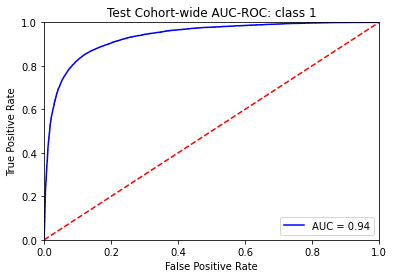

In [49]:
#from sophie's code - viz. the curve 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# fpr and tpr of all thresohlds
true = ground_truth
preds = probabilities[:, 1]
fpr, tpr, threshold = metrics.roc_curve(true, preds)

#get the metrics 
roc_auc = metrics.auc(fpr, tpr)

#plot
plt.title('Test Cohort-wide AUC-ROC: class 1')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

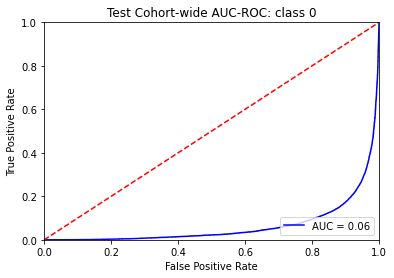

In [50]:
# fpr and tpr of all thresohlds
true = ground_truth
preds = probabilities[:, 0]
fpr, tpr, threshold = metrics.roc_curve(true, preds)

#get the metrics 
roc_auc = metrics.auc(fpr, tpr)

#plot
plt.title('Test Cohort-wide AUC-ROC: class 0')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Save Model 

In [ ]:
# PATH = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Saved_Models/resnet50.pt"
# torch.save(model.state_dict(), PATH) # here is how we save

In [47]:
# !nvidia-smi

Sun Dec 18 14:40:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   37C    P0    55W / 300W |   3758MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   